# Traitement d'images avec numpy et pydicom
------------

Nous avons utilisé `ImageJ` pour réaliser une correction de diffusé par la méthode de la triple fenêtre durant l'année de DQPRM. L'opération est assez aisée mais particulèrement fastidieuse compte tenu des nombreuses opérations nécessaires à cette correction.
De plus, durant le cours, certains paramètres tels que la largeur des fenêtres spectrométriques et leur position dans la pile d'images avaient été fournis. 

Dans cette exercice, nous vous proposons de réaliser la même correction mais en extrayant toutes les informations à partir des informations issues des images au format `dicom`. Pour cela, nous utiliserons le module `pydicom` pour l'interaction avec les fichiers dicom et `numpy` pour les opération sur les matrices images.

In [1]:
%matplotlib inline
import numpy as np
import pydicom as dcm
import SimpleITK as sitk

import matplotlib.pyplot as plt
from ipywidgets import interact

Ouvrons le fichier dicom

In [2]:
ds = dcm.read_file('./images/tomo1.dcm')
ds.PatientName

'DQPRM^optionnel'

## Récupération de certaines informations

In [3]:
print(ds.ImageType)
print(ds.Modality)

['ORIGINAL', 'PRIMARY', 'TOMO', 'EMISSION']
NM


L'image est une image de MN (`EMISSION`) acquise (`PRIMARY`) tomographique (`TOMO`)

In [4]:
pixel_size = ds.PixelSpacing[0]
nb_detect = int(ds.NumberOfDetectors)
nb_angle = int(ds[0x054,0x052][0][0x054,0x053].value)
duree_proj = float(ds[0x054,0x052][0][0x018,0x1242].value)
pos_radial_0 = ds[0x054,0x022][0][0x018,0x1142].value
pos_radial_1 = ds[0x054,0x022][1][0x018,0x1142].value
nb_energy_win = ds[0x054, 0x011].value
arr_energy_window = np.array(ds.EnergyWindowVector)
print('taille pixel (mm): ', pixel_size)
print('nb detecteurs: ', nb_detect)
print('nb angles: ', nb_angle)
print('durée projection (ms): ', duree_proj)
print('nb fenetres energie: ', nb_energy_win)
ds.NumberOfFrames
arr_energy_window

taille pixel (mm):  4.7951998710632
nb detecteurs:  2
nb angles:  32
durée projection (ms):  30003.0
nb fenetres energie:  5


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

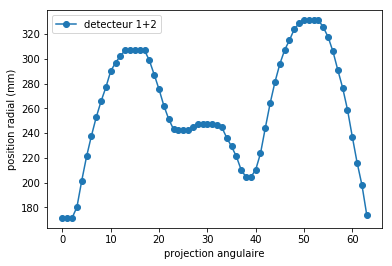

In [5]:
pos_radial_0 = [float(val) for val in pos_radial_0]
pos_radial_1 = [float(val) for val in pos_radial_1]
plt.plot(pos_radial_1+pos_radial_0,'o-', label='detecteur 1+2')
plt.xlabel('projection angulaire')
plt.ylabel('position radial (mm)')
plt.legend();

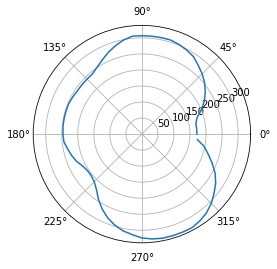

In [6]:
plt.polar([2*np.pi*l/64 for l in range(64)], 
          pos_radial_1+pos_radial_0);

On récupère l'image à l'aide de l'attribut `pixel_array` directement dans un `array` numpy.

In [7]:
arr_image = ds.pixel_array
print(ds.pixel_array.shape)

(320, 128, 128)


L'image est donc un tableau contenant 320 images de 128x128 pixels

Utilisons un dictionnaire (clé=valeur) pour stocker les informations relatives aux fenêtres en energie 

In [8]:
dic_energy = dict()
for en_i in range(nb_energy_win):
    limite_basse = float(ds.EnergyWindowInformationSequence[en_i][0x54,0x13][0][0x54,0x14].value)
    limite_haute = float(ds.EnergyWindowInformationSequence[en_i][0x54,0x13][0][0x54,0x15].value)
    pic_pos = np.mean([limite_basse, limite_haute])
    energy_width = limite_haute - limite_basse
    dic_energy[np.round(pic_pos,0)] = {'bas':limite_basse,
                                       'haut':limite_haute,
                                       'larg':energy_width,
                                       'pic':pic_pos,
                                       'pos_vec':en_i
                                      }

In [9]:
print(dic_energy)

{216.0: {'pos_vec': 2, 'bas': 203.77500915527, 'haut': 228.47500610352, 'larg': 24.699996948250003, 'pic': 216.125007629395}, 192.0: {'pos_vec': 4, 'bas': 184.89999389648, 'haut': 198.66000366211, 'larg': 13.760009765630002, 'pic': 191.779998779295}, 146.0: {'pos_vec': 3, 'bas': 133.30000305176, 'haut': 159.10000610352, 'larg': 25.80000305176, 'pic': 146.20000457764002}, 172.0: {'pos_vec': 1, 'bas': 159.10000610352, 'haut': 184.89999389648, 'larg': 25.799987792959996, 'pic': 172.0}, 247.0: {'pos_vec': 0, 'bas': 228.47500610352, 'haut': 265.52499389648, 'larg': 37.049987792959996, 'pic': 247.0}}


In [10]:
sorted(dic_energy.keys())

[146.0, 172.0, 192.0, 216.0, 247.0]

Les clés du dictionnaire ne sont pas ordonnées. Déterminons les indices des images qui correspondent aux fenêtres énergétique classées par ordre croissant.

In [11]:
ordered_window_energy = [dic_energy[k]['pos_vec'] for k in sorted(dic_energy.keys())]
print(ordered_window_energy)

[3, 1, 4, 2, 0]


Correction TEW sur le premier pic photo-électrique :
- l'indice 0 du vecteur `ordered_window_energy` correspond l'indice de la fenêtre basse 
- l'indice 2 du vecteur `ordered_window_energy` correspond l'indice de la fenêtre haute
- l'indice 1 du vecteur `ordered_window_energy` correspond l'indice de la fenêtre du pic photoélectrique

## Calcul de l'image TEW
-----------
Pour rappel, l'image corrigée de la diffusion par la méthode TEW est déterminée suivant la formule :
$$ I_{cor.} = I_{PE}  - (\frac{I_H}{w_H}+\frac{I_B}{w_B}) \times \frac{w_{20\%}}{2}$$

- $I_H,\, I_B, I_{PE}$ sont les images situées sur les fenêtres haute, basse et centré sur le pic photoélectrique respectivement
- $w_H,\, w_B$ sont les largeurs des fenêtres en énergie haute et basse respectivement


On détermine les indices du vecteur `arr_energy_window` qui correspondent aux fenêtres d'intérêt:

In [12]:
idx_bas = np.where(arr_energy_window == ordered_window_energy[0])
idx_haut = np.where(arr_energy_window == ordered_window_energy[2])
idx_pe = np.where(arr_energy_window == ordered_window_energy[1])
print(idx_bas)

(array([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191]),)


In [20]:
tew_image_basse = arr_image[idx_bas]#3
tew_image_haute = arr_image[idx_haut]#4
tew_image_pic = arr_image[idx_pe]#1
tew_image_pic.shape, tew_image_haute.shape, tew_image_basse.shape

((64, 128, 128), (64, 128, 128), (64, 128, 128))

Python permet d'écrire des lignes de codes concises et explicites. Le mécanisme de comprehension de liste en est un exemple.

In [22]:
width_image_basse = [dic_energy[key]['larg'] for key in dic_energy.keys() if dic_energy[key]['pos_vec'] == ordered_window_energy[0]][0]
width_image_haute = [dic_energy[key]['larg'] for key in dic_energy.keys() if dic_energy[key]['pos_vec'] == ordered_window_energy[2]][0]
width_image_pe = [dic_energy[key]['larg'] for key in dic_energy.keys() if dic_energy[key]['pos_vec'] == ordered_window_energy[1]][0]
tew_image_basse = tew_image_basse / width_image_basse
tew_image_haute = tew_image_haute / width_image_haute
img_corr = ((tew_image_haute+tew_image_basse)/2)*width_image_pe

On utilise le mécanisme de masque pour supprimer les valeurs négatives des images pouvant survenir à la suite de l'opération de soustraction pixel à pixel des 2 images `tew_image_pic` et `img_corr`. 

In [27]:
tew_img_corr = tew_image_pic - img_corr
tew_img_corr[tew_img_corr < 0] = 0
tew_img_corr = tew_img_corr.astype(np.int16)
print("nombre de coups dans l'image\nnon corrigée: {}\ncorrigée: {}".format(tew_image_pic[0].sum(), tew_img_corr[0].sum()))

nombre de coups dans l'image
non corrigée: 84149
corrigée: 72244


In [24]:
def plot_image(proj):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ax[0].imshow(tew_image_pic[proj], cmap=plt.cm.gray_r)
    ax[1].imshow(tew_img_corr[proj], cmap=plt.cm.gray_r)
interact(plot_image, proj=(0,63));

interactive(children=(IntSlider(value=31, description='proj', max=63), Output()), _dom_classes=('widget-intera…

Création d'un profil le long d'une ligne.

In [25]:
def compare_profil(proj, line):
    
    plt.plot(tew_image_pic[proj,line,:], label='uncorrected')
    plt.plot(tew_img_corr[proj,line,:], label='corrected')
    plt.legend();

interact(compare_profil, proj=(0,63), line=(22,104));

interactive(children=(IntSlider(value=31, description='proj', max=63), IntSlider(value=63, description='line',…

Création de l'image corrigée et sauvegarde dans un format d'images de type `mha`.

In [26]:
img_tew = sitk.GetImageFromArray(tew_img_corr)
sitk.WriteImage(img_tew,'test.mha')